In [2]:
import pandas as pd
import itertools
import collections
import numpy as np
from tqdm import tqdm
import gensim
import re
import json
import sklearn
import matplotlib.pyplot as plt

# Export neighbors for annotating
This notebook is to export the neighbors of the centroid of the complete, wildcard expanded query set for a few specific issues. These are exported to be used for manual annotation: take a random selection of occurences of these words in the corpus, stratified by similarity rank, and annotate whether they refer to the issue.

In [3]:
# This file is the output from the Issues_expand_wildcards.ipynb notebook
filename_issues = '/home/dafne/shared/FilterBubble/issue-positions/queries-asterix-expanded.csv'
filename_fasttext = '/home/dafne/shared/FilterBubble/word-embeddings/fasttext-aem-amcat50.bin'

In [4]:
# Load issues
df_issues = pd.read_csv(filename_issues)

In [5]:
# Load model
model = gensim.models.fasttext.load_facebook_model(filename_fasttext)

From the notebook `Query_set_expansion_CV_subset.ipynb` we (manually) determined the number of neighbors we want to explore, just beyond the elbow points of the recall graphs. In particular, we observe:
### Woning:
* Plot 1: recall around 1000, max f4 at 321
* Plot 2: first elbow around 1000, another jump at 2000, max f4 at 552

### bestVernieuw:
* Plot 1: recall elbow just before 1000, max f4 at 234
* Plot 2: elbow just before 1000, max f4 at 184

### Begrotingssaldo:
* Plot 1: recall elbow around 400, max f4 at 296
* Plot 2: elbow around 500, second jump after 1000. Max f4 at 214

### Coronaverspreiding:
* Plot 1: No clear elbow, recall continues to increase. Max f4 at 4842
* Plot 2: No clear elbow, recall continues to increase. Max f4 at 4969

For now, we choose to take the first 1500 neighbors, as this seems to be beyond the elbow for at least the first three issues.


In addition, we calculate the similarity for each of the original query terms to the centroid of the query terms. We add them to the list with the artificial rank -1, and they are put in their own strata for the stratified sampling.

In [6]:
issue_topn = {'woning': 1500, 
              'bestVernieuw': 1500, 
              'begrotingssaldo': 1500, 
              'coronaverspreiding': 1500}

In [7]:
def get_embedding(s, model):
    '''
    return fasttext embedding, but averaging over the words in the string
    '''
    return gensim.matutils.unitvec(model.wv[s.split()].mean(axis=0))

In [8]:
issues_nns = {}
for issue, topn in issue_topn.items():
    df_issues_sub = df_issues[(df_issues.issue == issue)]
    queries = df_issues_sub['query_preprocessed']
    seed_set = list(itertools.chain.from_iterable([q.split() for q in queries]))
    
    nearest_neighbors = pd.DataFrame(model.wv.most_similar(seed_set, topn=topn),
                                     columns=['word', 'similarity'])
    
    nearest_neighbors['rank'] = range(1, len(nearest_neighbors)+1)
    
    # compute similarities to centroid for original query words
    vectors = [get_embedding(q, model) for q in queries]
    centroid = gensim.matutils.unitvec(np.array(vectors).mean(axis=0))
    nearest_neighbors = nearest_neighbors.append(pd.DataFrame({
        'word': queries,
        'similarity': model.wv.cosine_similarities(centroid, vectors),
        'rank': -1
    })).reset_index(drop=True)
    
    # Divide into strata of size 100
    strata_size = 100
    nearest_neighbors['strata'] = np.abs(np.ceil(nearest_neighbors['rank'] / strata_size))
    issues_nns[issue] = nearest_neighbors

To get insight in the similarity values of both the neighbors and the original terms, we plot the similarity by rank, and a boxplot of the similarities of the original query terms. (be aware that the scale of the y-axis is different for the different issues)

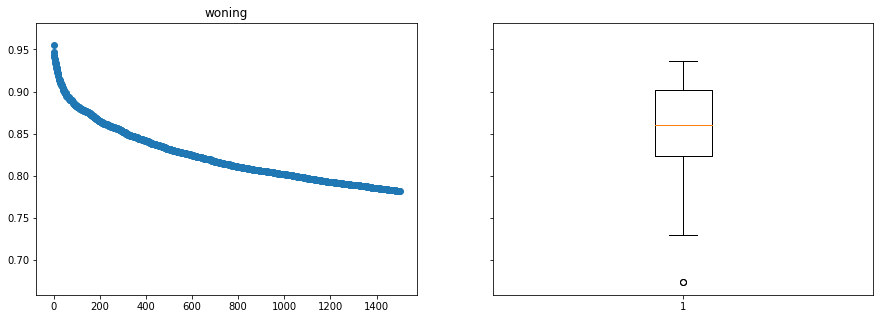

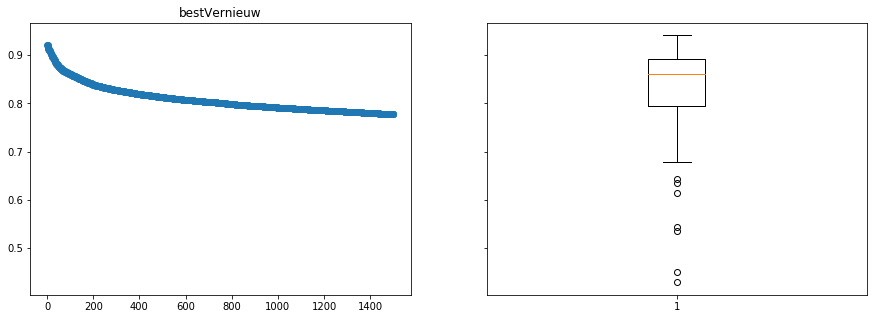

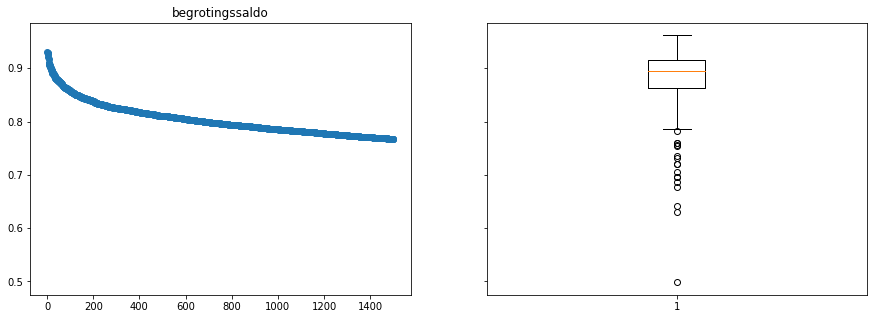

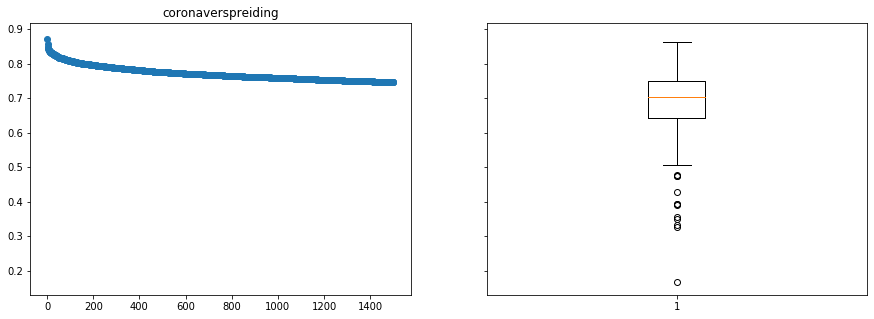

In [9]:
for issue in issues_nns:
    nn_df = issues_nns[issue]
    fig, axes = plt.subplots(1,2, sharey=True, figsize=(15,5))
    nn_df_sub = nn_df[nn_df['rank']>=0]
    axes[0].scatter(nn_df_sub['rank'], nn_df_sub['similarity'])
    axes[1].boxplot(nn_df[nn_df['rank']==-1]['similarity'])
    axes[0].set_title(issue)
    plt.show()

In [10]:
# Output as csv
import os
output_path = '/home/dafne/shared/FilterBubble/issue-positions/nearest-neighbors/'
for issue, nn_df in issues_nns.items():
    nn_df.to_csv(os.path.join(output_path, '{}.csv'.format(issue)), index=False)